In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

from util import load_data, fdr, fdr_prob

In [2]:
x_train, x_test, x_oot, y_train, y_test, y_oot = load_data('var_30.csv')
x_train.head()

,fulladdress_count_1_by_7,address_count_0,ssn_count_3,fulladdress_count_0,homephone_count_7,address_count_1_by_7,name_dob_count_3,name_count_7,homephone_count_3,fulladdress_homephone_count_0_by_14,...,ssn_dob_count_7,ssn_name_count_7,name_day_since,ssn_firstname_count_14,ssn_count_7,name_count_14,fulladdress_count_1_by_14,fulladdress_homephone_count_0_by_30,ssn_lastname_count_14,ssn_name_count_14
195315,0.09144,-0.042158,-0.047591,-0.041351,-0.769214,0.103441,-0.046415,-0.115648,-0.521454,0.120387,...,-0.055708,-0.057109,0.598116,-0.071088,-0.058092,-0.159376,0.123861,0.166392,-0.071051,-0.070962
436134,0.09144,-0.042158,-0.047591,-0.041351,0.879479,0.103441,-0.046415,-0.115648,0.639149,0.120387,...,-0.055708,-0.057109,0.598116,-0.071088,-0.058092,-0.159376,0.123861,0.166392,-0.071051,-0.070962
339605,0.09144,-0.042158,-0.047591,-0.041351,-0.769214,0.103441,-0.046415,-0.115648,-0.521454,0.120387,...,-0.055708,-0.057109,0.598116,-0.071088,-0.058092,-0.159376,0.123861,0.166392,-0.071051,-0.070962
536275,0.09144,-0.042158,-0.047591,-0.041351,-0.769214,0.103441,-0.046415,-0.115648,-0.521454,0.120387,...,-0.055708,-0.057109,-0.720792,-0.071088,-0.058092,-0.159376,0.123861,0.166392,-0.071051,-0.070962
461401,0.09144,-0.042158,-0.047591,-0.041351,-0.769214,0.103441,-0.046415,-0.115648,-0.521454,0.120387,...,-0.055708,-0.057109,0.598116,-0.071088,-0.058092,-0.159376,0.123861,0.166392,-0.071051,-0.070962


In [3]:
# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
x_train, x_train_lr, y_train, y_train_lr = train_test_split(x_train, y_train, test_size=0.5)

In [4]:
# Supervised transformation based on random forests
rf = RandomForestClassifier(n_estimators=300,
                            max_depth=17, 
                            max_features=10,
                            ccp_alpha=1e-6, 
                            n_jobs=8)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression(C=1, max_iter=1000)
rf.fit(x_train, y_train)
rf_enc.fit(rf.apply(x_train))
rf_lm.fit(rf_enc.transform(rf.apply(x_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(x_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)
print(fdr_prob(y_test, y_pred_rf_lm))

0.5449438202247191


In [5]:
# Supervised transformation based on gradient boosted trees
grd = GradientBoostingClassifier(max_depth=10,
                                 n_estimators=100,
                                 learning_rate=0.05,
                                 subsample=0.5)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression(C=1, max_iter=1000)
grd.fit(x_train, y_train)
grd_enc.fit(grd.apply(x_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(x_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(x_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)
print(fdr_prob(y_test, y_pred_grd_lm))

0.5514261019878998


In [6]:
# The random forest model by itself
y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(fdr_prob(y_test, y_pred_rf))

0.5561797752808989


In [7]:
# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(x_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
print(fdr_prob(y_test, y_pred_grd))

0.5535868625756266


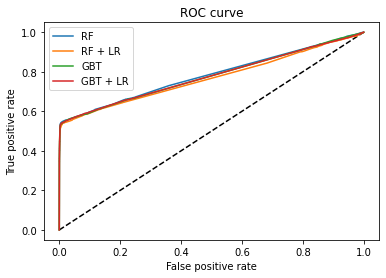

In [8]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

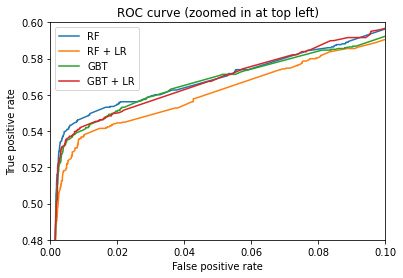

In [9]:
plt.figure(2)
plt.xlim(0, 0.1)
plt.ylim(0.48, 0.6)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()